<a href="https://colab.research.google.com/github/lmn190104/yolov5-AI/blob/main/B%E1%BA%A3n_sao_c%E1%BB%A7a_Codegit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!git clone https://github.com/ultralytics/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [4]:
!pip install --quiet opencv-python-headless torch torchvision

import os
import cv2
import torch
import numpy as np
import glob
from torchvision import transforms
from matplotlib import pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image




In [5]:
# --------- 1. Hàm xử lý ảnh và nhãn ------------
def preprocess_image_and_label(img_path, label_path, img_size=416):
    # Load và resize ảnh
    img = Image.open(img_path).convert('RGB')
    img = img.resize((img_size, img_size))
    img_tensor = transforms.ToTensor()(img)  # [C, H, W], giá trị [0,1]

    # Đọc nhãn định dạng YOLO: class_id x_center y_center width height (tính theo tỉ lệ)
    with open(label_path, 'r') as f:
        lines = f.readlines()

    labels = []
    for line in lines:
        parts = list(map(float, line.strip().split()))
        labels.append(parts)

    label_tensor = torch.tensor(labels)  # [num_objects, 5]
    return img_tensor, label_tensor

In [6]:
class YoloDataset(Dataset):
    def __init__(self, image_paths, labels_folder, transform=None):
        self.image_paths = image_paths
        self.labels_folder = labels_folder
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        file_name = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(self.labels_folder, file_name + '.txt')

        img_tensor, label_tensor = preprocess_image_and_label(img_path, label_path)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, label_tensor


In [7]:
# Đường dẫn dữ liệu
images_folder = '/content/drive/MyDrive/TTNTN10/unzipped_data/TRITUENHANTAOnhom10K/images/'
labels_folder = '/content/drive/MyDrive/TTNTN10/unzipped_data/TRITUENHANTAOnhom10K/labels/'

# Tạo dataset
dataset = YoloDataset(images_folder, labels_folder)

# Tạo dataloader với batch_size phù hợp RAM
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))


In [8]:
from sklearn.model_selection import train_test_split
import glob, os

# Lấy danh sách ảnh
all_image_paths = sorted(glob.glob(os.path.join(images_folder, '*.jpg')) +
                         glob.glob(os.path.join(images_folder, '*.png')))

# Chia train/val
train_paths, val_paths = train_test_split(all_image_paths, test_size=0.2, random_state=42)

# Tạo dataset và dataloader
train_dataset = YoloDataset(train_paths, labels_folder)
val_dataset = YoloDataset(val_paths, labels_folder)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))


In [9]:
import os
import shutil
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import glob

# ==== 1. Cấu hình đường dẫn gốc ====

images_folder = '/content/drive/MyDrive/TTNTN10/unzipped_data/TRITUENHANTAOnhom10K/images'  # <-- chỉnh đường dẫn này
labels_folder = '/content/drive/MyDrive/TTNTN10/unzipped_data/TRITUENHANTAOnhom10K/labels' # <-- chỉnh đường dẫn này

output_base = '/content/yolov5/data_cleaned'  # <-- nơi lưu tập dữ liệu sau khi chia

# ==== 2. Lấy tất cả ảnh ====
all_image_paths = sorted(glob.glob(os.path.join(images_folder, '*.jpg')) +
                         glob.glob(os.path.join(images_folder, '*.png')))

# ==== 3. Chia train / val ====
train_paths, val_paths = train_test_split(all_image_paths, test_size=0.2, random_state=42)

# ==== 4. Tạo thư mục cần thiết ====
for split in ['train', 'val']:
    os.makedirs(os.path.join(output_base, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_base, split, 'labels'), exist_ok=True)

# ==== 5. Hàm sao chép ảnh & nhãn ====
def copy_data(image_paths, split):
    for img_path in tqdm(image_paths, desc=f'Copying {split} data'):
        file_name = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(labels_folder, file_name + '.txt')

        # Đích đến
        img_dest = os.path.join(output_base, split, 'images', os.path.basename(img_path))
        label_dest = os.path.join(output_base, split, 'labels', file_name + '.txt')

        # Copy ảnh
        if os.path.exists(img_path):
            shutil.copy(img_path, img_dest)

        # Copy nhãn
        if os.path.exists(label_path):
            shutil.copy(label_path, label_dest)
        else:
            print(f"[!] Thiếu nhãn: {label_path}")

# ==== 6. Thực hiện copy ====
copy_data(train_paths, 'train')
copy_data(val_paths, 'val')


Copying val data: 100%|██████████| 448/448 [04:55<00:00,  1.52it/s]


In [10]:
yaml_contentt = """
train: /content/yolov5/data_cleaned/train
val: /content/yolov5/data_cleaned/val

nc: 5
names: ['o to', 'xe bus', 'xe dap', 'xe may', 'xe tai']
"""

with open('datalmn.yaml', 'w') as f:
    f.write(yaml_contentt)



In [11]:
!python /content/yolov5/train.py --img 640 --batch 16 --epochs 10 --data /content/datalmn.yaml --weights yolov5s.pt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-06-13 08:36:57.532555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749803817.766723   15797 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749803817.821791   15797 cuda_blas.cc:1418] Unable to

In [13]:
!python /content/yolov5/detect.py --source /content/yolov5/data/images --weights /content/yolov5/runs/train/exp/weights/best.pt --conf 0.25 --save-txt

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/yolov5/data/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-421-g79c4c31d Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
image 1/14 /content/yolov5/data/images/Mix_010_JPG.rf.ed74f1733ea62e8ff9f21d2823f9c111.jpg: 640x640 6 o tos, 18 xe mays, 1 xe tai, 11.5ms
image 2/14 /content/yolov5/data/images/Mix_014_JPG.rf.bf353088b7da37b03ccb0d6a8f51094b.jpg: 640x640 6 o tos, 2 xe daps, 16 xe mays, 1 xe ta

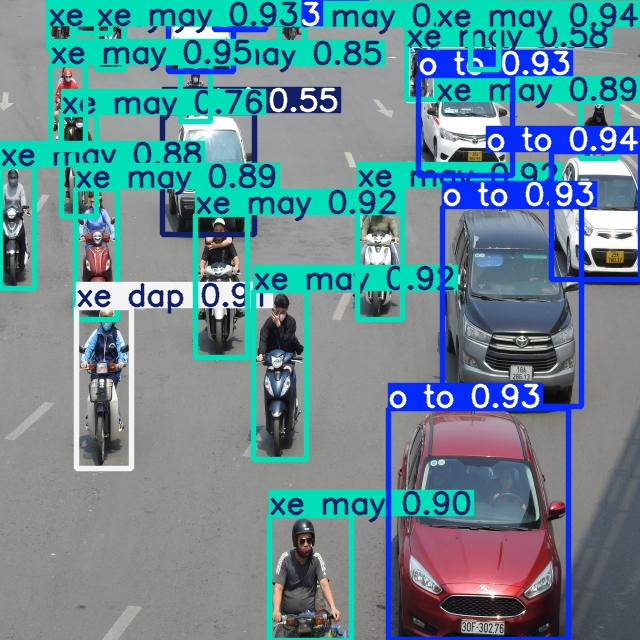

In [14]:
import glob
from IPython.display import Image, display

# Lấy danh sách ảnh kết quả
result_images = glob.glob('/content/yolov5/runs/detect/exp2/*.jpg')

# Hiển thị 3 ảnh đầu tiên với kích thước 640x640
for img_path in result_images[:1]:
    display(Image(filename=img_path, height=640))



[🔍] Kiểm tra: Mix_014_JPG.rf.bf353088b7da37b03ccb0d6a8f51094b
 → Phát hiện object: xe dap
 → Phát hiện object: xe tai
 → Phát hiện object: xe may
 → Phát hiện object: o to
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: xe dap
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: o to
 → Phát hiện object: xe may
 → Phát hiện object: o to
 → Phát hiện object: o to
 → Phát hiện object: o to
 → Phát hiện object: o to
 → Phát hiện object: xe may
 → Phát hiện object: xe may

[🔍] Kiểm tra: Mix_014_JPG.rf.bf353088b7da37b03ccb0d6a8f51094b
→ Object 0: xe dap   ❌ VI PHẠM
→ Object 1: xe tai   ✔️ Hợp lệ
→ Object 2: xe may   ❌ VI PHẠM
→ Object 3: o to     ✔️ Hợp lệ
→ Object 4: xe may   ❌ VI PHẠM
→ Object 5: xe may   ❌ VI PHẠM


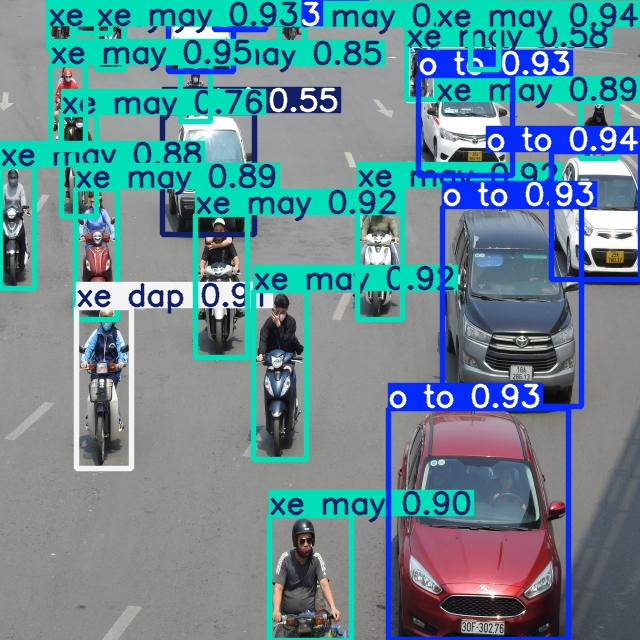


[🔍] Kiểm tra: Mix_022_JPG.rf.a2b681ca988bbce96f4f09bfe27cb55b
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: o to
 → Phát hiện object: xe may
 → Phát hiện object: xe bus
 → Phát hiện object: xe may
 → Phát hiện object: o to
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: o to
 → Phát hiện object: o to
 → Phát hiện object: o to
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: o to
 → Phát hiện object: xe may
 → Phát hiện object: o to
 → Phát hiện object: o to

[🔍] Kiểm tra: Mix_022_JPG.rf.a2b681ca988bbce96f4f09bfe27cb55b
→ Object 0: xe may   ❌ VI PHẠM
→ Object 1: xe may   ❌ VI PHẠM
→ Object 2: xe may   ❌ VI PHẠM
→ Object 3: xe may   ❌ VI PHẠM
→ Object 4: xe may   ❌ VI PHẠM
→ Object 5: o to     ✔️ Hợp lệ
→ Object 6: xe may   ❌ VI PHẠM
→ Object 7: xe bus   ❌ VI PHẠM
→ Object 8: xe may   ❌ VI 

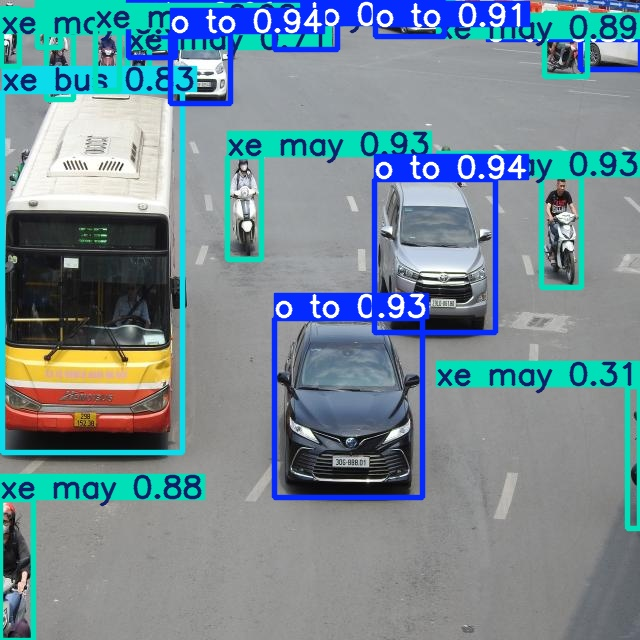


[🔍] Kiểm tra: Mix_109_JPG.rf.ecd2159499155eeb322fef46997657c6
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: xe may

[🔍] Kiểm tra: Mix_109_JPG.rf.ecd2159499155eeb322fef46997657c6
→ Object 0: xe may   ❌ VI PHẠM
→ Object 1: xe may   ❌ VI PHẠM
→ Object 2: xe may   ❌ VI PHẠM
→ Object 3: xe may   ❌ VI PHẠM
→ Object 4: xe may   ❌ VI PHẠM
→ Object 5: xe may   ❌ VI PHẠM
→ Object 6: xe may   ❌ VI PHẠM
→ Object 7: xe may   ❌ VI PHẠM
✅ Tổng cộng 8 VI PHẠM trong ảnh
Ảnh Mix_109_JPG.rf.ecd2159499155eeb322fef46997657c6.jpg ✅ VI PHẠM


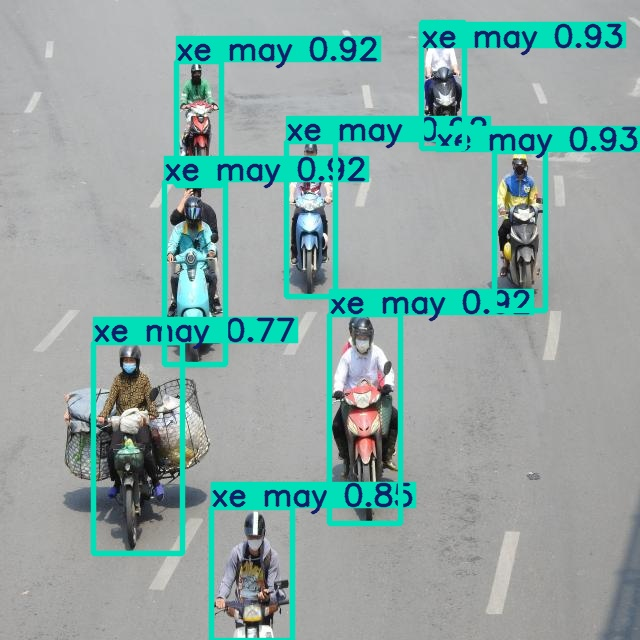

In [16]:
import glob
from IPython.display import Image, display
import os

# Định nghĩa danh sách các nhãn vi phạm
VIOLATION_CLASSES = ['xe may', 'xe dap', 'xe bus']

# Đường dẫn tới thư mục chứa kết quả phát hiện
detect_folder = '/content/yolov5/runs/detect/exp2'

# Hàm kiểm tra xem ảnh có chứa nhãn vi phạm không
def analyze_objects(label_path, class_names, violation_classes):
    if not os.path.exists(label_path):
        print(f"[❌] Không tìm thấy file nhãn: {label_path}")
        return False

    with open(label_path, 'r') as f:
        lines = f.readlines()

    violated = 0

    print(f"\n[🔍] Kiểm tra: {os.path.basename(label_path).replace('.txt', '')}")
    for idx, line in enumerate(lines):
        parts = line.strip().split()
        class_id = int(parts[0])
        class_name = class_names[class_id]

        if class_name in violation_classes:
            print(f"→ Object {idx}: {class_name:<8} ❌ VI PHẠM")
            violated += 1
        else:
            print(f"→ Object {idx}: {class_name:<8} ✔️ Hợp lệ")

    print(f"✅ Tổng cộng {violated} VI PHẠM trong ảnh")
    return violated > 0


# Danh sách tên class từ file YAML
class_names = ['o to', 'xe bus', 'xe dap', 'xe may', 'xe tai']

# Lấy danh sách ảnh kết quả
result_images = glob.glob(os.path.join(detect_folder, '*.jpg'))

# Hiển thị 3 ảnh đầu tiên với kích thước 640x640 và kiểm tra vi phạm
for img_path in result_images[:3]:
    file_name = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(detect_folder, 'labels', file_name + '.txt')

    if not os.path.exists(label_path):
        print(f"[❌] Không tìm thấy file nhãn: {label_path}")
        continue

    print(f"\n[🔍] Kiểm tra: {file_name}")
    with open(label_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        class_id = int(line.split()[0])
        class_name = class_names[class_id]
        print(f" → Phát hiện object: {class_name}")

    if analyze_objects(label_path, class_names, VIOLATION_CLASSES):
      print(f"Ảnh {os.path.basename(img_path)} ✅ VI PHẠM")
    else:
      print(f"Ảnh {os.path.basename(img_path)} ❎ KHÔNG vi phạm")

# Hiển thị ảnh___
    display(Image(filename=img_path, width=640, height=640))


In [18]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 127.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 124.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.6 MB/s eta 0:00:00


In [23]:
!npm install -g localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴
added 22 packages in 2s
⠴
⠴3 packages are looking for funding
⠴  run `npm fund` for details
⠴

import streamlit as st
import os
import subprocess
import glob
from PIL import Image

In [20]:
# ==== CONFIG ==== #
DETECT_SCRIPT = 'yolov5/detect.py'
MODEL_PATH = 'yolov5/runs/train/exp/weights/best.pt'
DETECT_FOLDER = 'yolov5/runs/detect'
VIOLATION_CLASSES = ['xe may', 'xe dap', 'xe bus']
CLASS_NAMES = ['o to', 'xe bus', 'xe dap', 'xe may', 'xe tai']

In [22]:
!pip install streamlit colabcode


Requested uvicorn==0.13.1 from https://files.pythonhosted.org/packages/ef/67/546c35e9fffb585ea0608ba3bdcafe17ae402e304367203d0b08d6c23051/uvicorn-0.13.1-py3-none-any.whl (from colabcode) has invalid metadata: .* suffix can only be used with `==` or `!=` operators
    python-dotenv (>=0.13.*) ; extra == 'standard'
                   ~~~~~~~^
Please use pip<24.1 if you need to use this version.
INFO: pip is looking at multiple versions of colabcode to determine which version is compatible with other requirements. This could take a while.
  Using cached uvicorn-0.13.1-py3-none-any.whl.metadata (4.6 kB)
Requested uvicorn==0.13.1 from https://files.pythonhosted.org/packages/ef/67/546c35e9fffb585ea0608ba3bdcafe17ae402e304367203d0b08d6c23051/uvicorn-0.13.1-py3-none-any.whl (from colabcode) has invalid metadata: .* suffix can only be used with `==` or `!=` operators
    python-dotenv (>=0.13.*) ; extra == 'standard'
                   ~~~~~~~^
Please use pip<24.1 if you need to use this versio

In [21]:
# ==== APP ==== #
st.set_page_config(page_title="Demo Phát hiện vi phạm giao thông", layout="wide")
st.title("🚦 YOLOv5 - Phát hiện phương tiện vi phạm")


2025-06-13 08:59:07.109 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-13 08:59:07.115 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-13 08:59:07.306 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-06-13 08:59:07.310 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [41]:
# ==== UPLOAD ==== #
uploaded_files = st.file_uploader("📤 Upload ảnh cần kiểm tra", type=['jpg', 'png'], accept_multiple_files=True)

if uploaded_files:
    os.makedirs("temp_uploads", exist_ok=True)
    input_paths = []

    st.subheader("📸 Ảnh đã tải lên:")
    cols = st.columns(len(uploaded_files))
    for idx, file in enumerate(uploaded_files):
        path = os.path.join("temp_uploads", file.name)
        with open(path, 'wb') as f:
            f.write(file.read())
        input_paths.append(path)
        cols[idx].image(path, use_column_width=True)

    if st.button("🚀 Phát hiện vi phạm"):
        st.info("Đang chạy mô hình YOLOv5...")



2025-06-13 10:12:03.286 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-13 10:12:03.287 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-13 10:12:03.288 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-13 10:12:03.289 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-13 10:12:03.290 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [43]:
# Run detect.py
result = subprocess.run([
    'python', DETECT_SCRIPT,
    '--source', 'temp_uploads',
    '--weights', MODEL_PATH,
    '--conf', '0.25',
    '--save-txt',
    '--save-conf'
], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

st.text(result.stdout)
if result.stderr:
    st.error(result.stderr)


2025-06-13 10:12:55.530 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-13 10:12:55.531 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-13 10:12:55.533 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-13 10:12:55.533 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [45]:
# === Phân tích kết quả ===
st.success("✅ Phát hiện xong! Hiển thị kết quả bên dưới.")

latest_folder = sorted(glob.glob(f"{DETECT_FOLDER}/exp*"), key=os.path.getmtime)[-1]
result_images = glob.glob(os.path.join(latest_folder, '*.jpg'))

for img_path in result_images:
    file_name = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(latest_folder, 'labels', file_name + '.txt')

    st.image(img_path, caption=f"Kết quả: {file_name}", use_column_width=True)

    if not os.path.exists(label_path):
        st.warning(f"Không tìm thấy nhãn cho {file_name}.")
        continue

    with open(label_path, 'r') as f:
        lines = f.readlines()

    violated = 0
    for idx, line in enumerate(lines):
        parts = line.strip().split()
        class_id = int(parts[0])
        class_name = CLASS_NAMES[class_id]

        if class_name in VIOLATION_CLASSES:
            violated += 1
            st.markdown(f"- 🚫 Object {idx+1}: `{class_name}` **VI PHẠM**")
        else:
            st.markdown(f"- ✅ Object {idx+1}: `{class_name}` hợp lệ")

    if violated:
        st.error(f"⛔ Ảnh này có **{violated} phương tiện vi phạm**.")
    else:
        st.success("✅ Không có vi phạm phát hiện.")


2025-06-13 10:14:53.902 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-13 10:14:53.903 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
